In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import  matplotlib.cm as cm
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
import matplotlib as mpl
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_profiles
from salishsea_tools import nc_tools, viz_tools

In [96]:
path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/upwelling_events/eventB_pulse10_bdy' 
gridT = xr.open_dataset(path+'/GYRE_1h_20170101_20170120_grid_T.nc')
gridU = xr.open_dataset(path+'/GYRE_1h_20170101_20170120_grid_U.nc')
gridV = xr.open_dataset(path+'/GYRE_1h_20170101_20170120_grid_V.nc')
gridW = xr.open_dataset(path+'/GYRE_1h_20170101_20170120_grid_W.nc')
mesh_mask = xr.open_dataset(path+'/mesh_mask.nc')

In [104]:
tmask0_rest = 1 - np.asfarray(mesh_mask['tmask'])[:]
time_len = U_vel.shape[0]
tmask_rest = np.tile(tmask0_rest, (time_len, 1, 1, 1))

In [105]:
deptht = np.asfarray(gridT['deptht'])
utau = np.asfarray(gridU['sozotaux'])
vtau = np.asfarray(gridV['sometauy'])
U_vel = np.ma.array(np.asfarray(gridU['vozocrtx']), mask=tmask_rest)
V_vel = np.ma.array(np.asfarray(gridV['vomecrty']), mask=tmask_rest)
time_counter = gridT['time_counter']

In [4]:
sal = nc.Dataset('../conditions/NEMO_files/salinity/salinity_doubled_20.nc')['vosaline']
tem = nc.Dataset('../conditions/NEMO_files/temperature/temperature_doubled_20.nc')['votemper']

In [5]:
bathy_file = nc.Dataset('../bathymetry/NEMO_files/idealized/ideal_bathy_05.nc')
ideal = bathy_file['Bathymetry']

# Initial Conditions

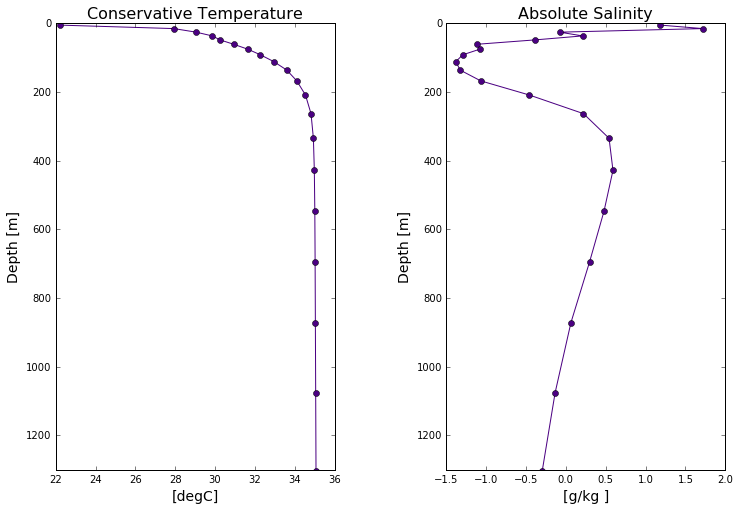

In [35]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 8))
ttls = ['Conservative Temperature', 'Absolute Salinity']
for ax, var, ttl in zip([ax1, ax2], [sal,tem], ttls):
    ax.plot(var[0,:,0,0], deptht, marker='o', color='indigo')
    ax.set_ylim([1300, 0])
    ax.set_title(ttl, fontsize=16)
    ax.set_ylabel('Depth [m]', fontsize=14)
ax1.set_xlabel('[degC]', fontsize=14)
ax2.set_xlabel('[g/kg ]', fontsize=14)
fig.subplots_adjust(wspace=0.4)
#plt.savefig('initialconditions.png')

# Wind Forcing

In [36]:
def load_month(filename):
    data = pd.read_csv(filename, skiprows=16, encoding='ISO-8859-1')
    return data

def convert_times(dates):
    times_all = []
    for ii in range(0, len(dates)):
        times_new = datetime.strptime(dates[ii], '%Y-%m-%d %H:%M')
        times_all.append(times_new)
    return times_all

def get_data_day(data, day):
    wind_speed = np.array(data['Wind Spd (km/h)'])
    wind_dir = np.array(data['Wind Dir (10s deg)']) #
    date_time = np.array(data['Date/Time'])
    day_index = np.where(data['Day']==day)   
    dates_day = convert_times(date_time[day_index])
    
    wind_speed_day = wind_speed[day_index] * 1000 / 3600
    wind_dir_day = wind_dir[day_index] * 10 #
    return dates_day, wind_speed_day, wind_dir_day

def get_data_range(data, days_start, days_end):
    n_hours = 24
    days_range = np.arange(days_start,days_end+1)
    wind_speed_range = np.zeros((len(days_range),n_hours))
    wind_dir_range = np.zeros_like(wind_speed_range) #
    dates_range = []
    for day, n in zip(days_range, np.arange(len(wind_speed_range))):
        dates_day, wind_speed_day, wind_dir_day = get_data_day(data, day) #
        wind_speed_range[n, :] = wind_speed_day
        wind_dir_range[n, :] = wind_dir_day #
        dates_range = np.append(dates_range, dates_day)
    wind_speed_range = wind_speed_range.flatten()
    wind_dir_range = wind_dir_range.flatten() #
    return dates_range, wind_speed_range, wind_dir_range

def convert_wind_stress(wind_speed_range):
    wind_stress_range = 1.25 * (1.5 * 10**-3) * (wind_speed_range**2)
    return wind_stress_range

def convert_angle_component(speed, angle):
    xcomp = -1 * speed * np.sin(np.deg2rad(angle))
    return xcomp

def combine_ranges(data_list, start_list, end_list):
    date_all = []
    speed_all = []
    stress_all = []

    for data, start, end in zip(data_list, start_list, end_list):
        dates, speed, direc = get_data_range(data, start, end) #
        stress = convert_wind_stress(speed)
        stress_x = convert_angle_component(stress, direc) #
        

        date_all = np.append(date_all, dates)
        speed_all = np.append(speed_all, speed)
        stress_all = np.append(stress_all, stress_x)
    
    return date_all, speed_all, stress_all

def plot_range(ax, dates, wind_stress, ymin = -0.3, ymax=0.3):
    ax.plot(dates, wind_stress, linewidth=1.5, color='royalblue')
    ax.yaxis.grid()
    ax.set_ylim([ymin, ymax])
    ax.axhline(0, c='k')
    return ax

def upwelling_event(ax, date_all, year, month, day, hr, label, inds, ev, y=-0.14):
    if ev == 'upw':
        c = 'indianred'
    elif ev == 'wnd':
        c = 'indigo'
    elif ev == 'wnd2':
        c = 'orchid'
    elif ev == 'dta':
        c = 'darkgreen'
    else:
        c = 'k'
    ind = np.where(date_all == datetime(year, month, day, hr, 0))[0][0]
    ax.axvline(date_all[ind], color=c, linewidth=3.5)
    ax.text(date_all[ind+inds], y, label, rotation=90, fontsize=16)
    return ax

In [37]:
nov87 = load_month('../conditions/data/for_atmospheric_forcing/eng-hourly-11011987-11301987.csv')
oct87 = load_month('../conditions/data/for_atmospheric_forcing/eng-hourly-10011987-10311987.csv')

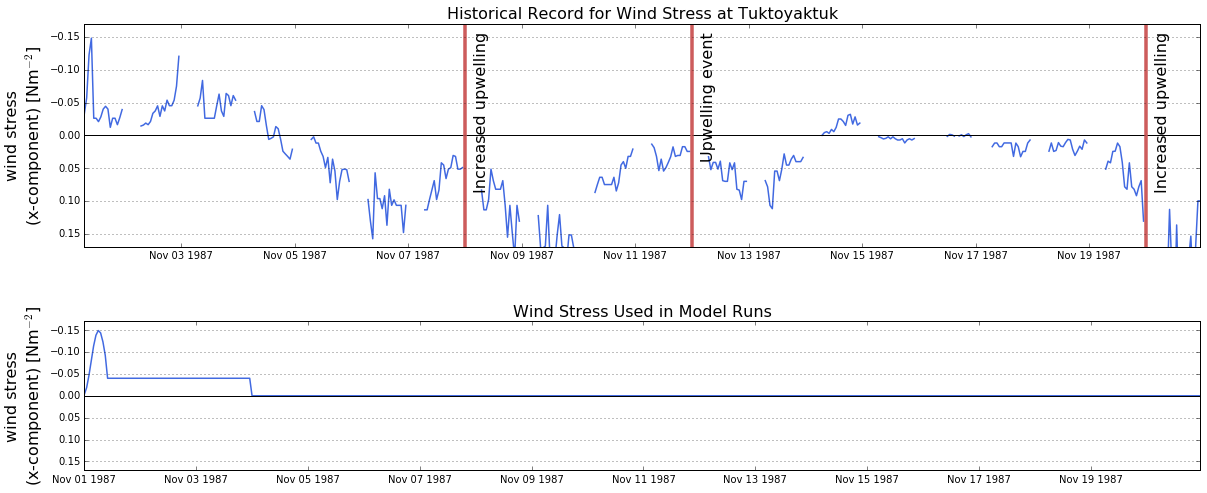

In [38]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(2, 1,height_ratios=[3, 2])

ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

data_list = [nov87]
start_list = [1]
end_list = [20]
date_all, speed_all, stress_all = combine_ranges(data_list, start_list, end_list)
ax = plot_range(ax, date_all, -1 * stress_all, -0.18, 0.18)
ax = upwelling_event(ax, date_all, 1987, 11, 12, 0, 'Upwelling event', 4, 'upw')
ax = upwelling_event(ax, date_all, 1987, 11, 8, 0, 'Increased upwelling', 4, 'upw')
ax = upwelling_event(ax, date_all, 1987, 11, 20, 0, 'Increased upwelling', 4, 'upw')
ax.set_title('Historical Record for Wind Stress at Tuktoyaktuk', fontsize=16)
ax.set_ylim([0.17, -0.17])
ax.set_ylabel('wind stress\n(x-component) [Nm$^{-2}$]', fontsize=16)

ax2 = plot_range(ax2, date_all, utau[:,0,0], -0.18, 0.18)
ax2.set_ylim([0.17, -0.17])
ax2.set_ylabel('wind stress\n(x-component) [Nm$^{-2}$]', fontsize=16)
ax2.set_title('Wind Stress Used in Model Runs', fontsize=16)

fig.subplots_adjust(hspace=0.4)

#plt.savefig('windforcing.png')

# Boundary Conditions

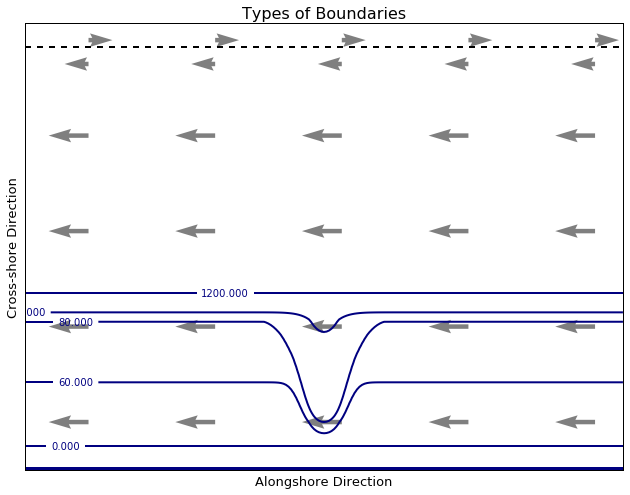

In [39]:
fig, ax = plt.subplots(1,1,figsize=(237/177*8,8))
c = ax.contour(ideal[:,:], levels = [0, 60, 80, 400, 1200], colors = 'navy', linewidths=2)
ax.clabel(c, inline=1, fontsize=10)
ax.axhline(0, lw=6, c='navy')

def make_quiver(y, u, v):
    X = np.arange(25, 226, 50)
    Y = np.ones(len(X)) * y
    U = np.ones(len(X)) * u
    V = np.ones(len(X)) * v
    ax.quiver(X,Y,U,V, alpha=0.5, scale=150)

make_quiver(20, -10, 0)
make_quiver(60, -10, 0)
make_quiver(100, -10, 0)
make_quiver(140, -10, 0)

make_quiver(170, -6, 0)
make_quiver(180, 6, 0)

ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])

ax.set_title('Types of Boundaries', fontsize=16)
plt.xlabel('Alongshore Direction', fontsize=13)
plt.ylabel('Cross-shore Direction', fontsize=13)

ax.set_ylim([0, ideal.shape[0]+10])
ax.axhline(ideal.shape[0], c='k', linewidth=2, linestyle='--')

#plt.savefig('boundaryconditions.png')

# Preliminary Results

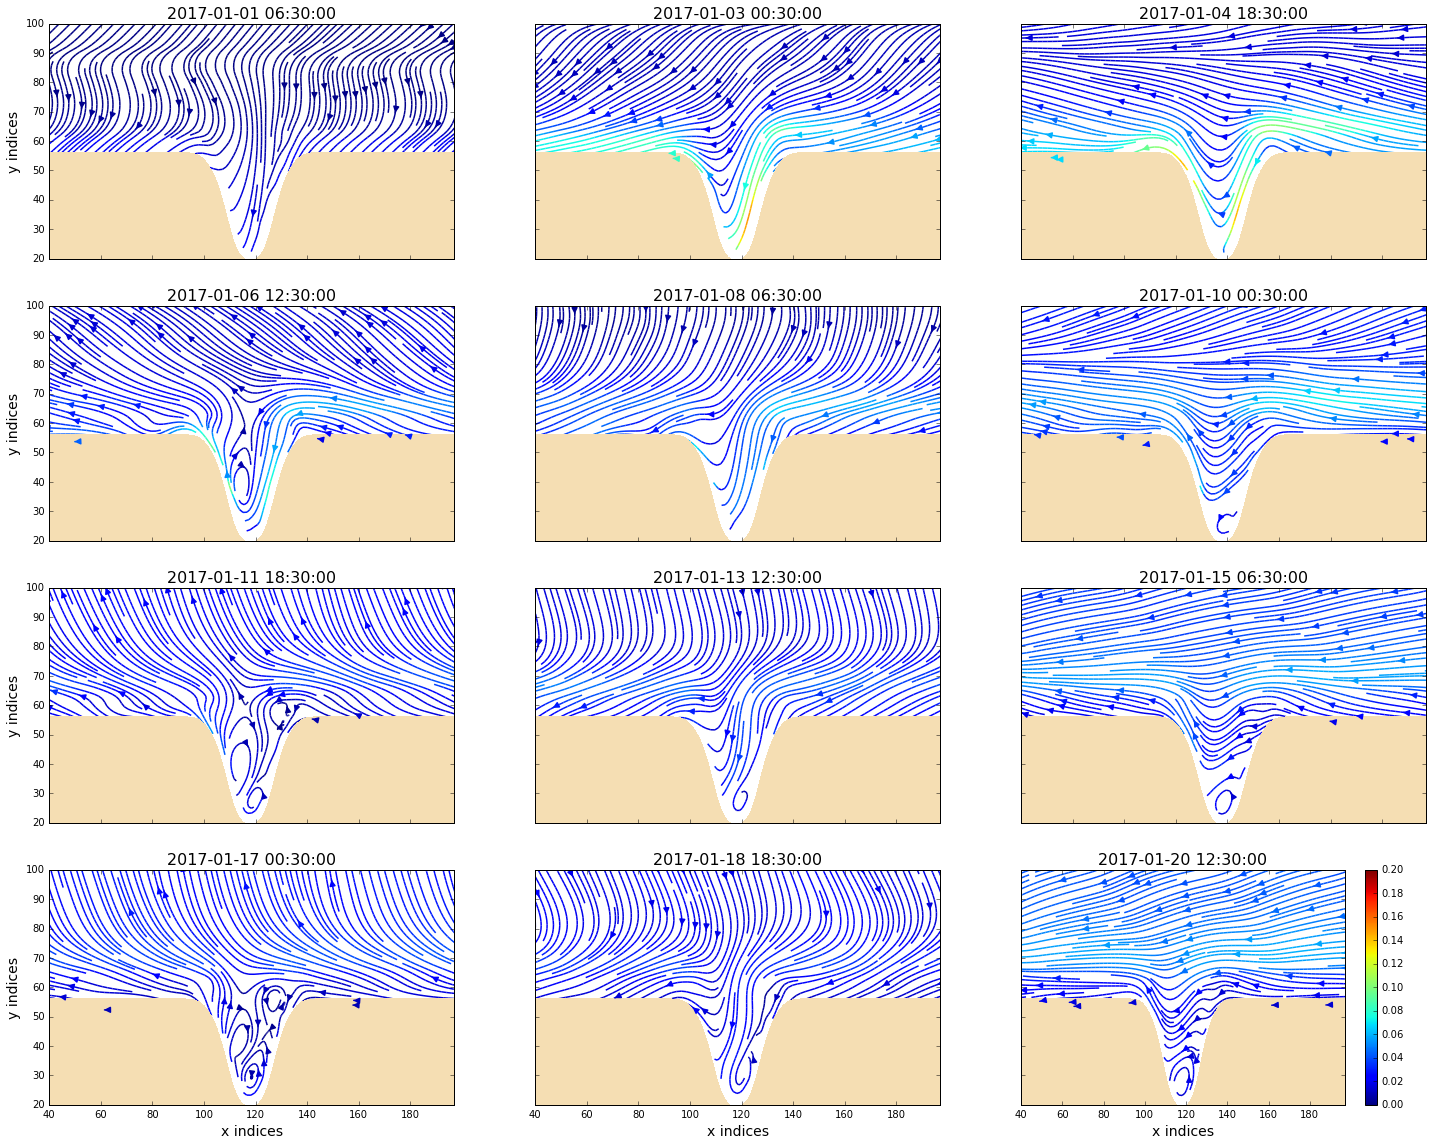

In [108]:
fig, ax = plt.subplots(4,3,figsize=(20, 16), sharex=True, sharey=True)
ax = ax.flatten()
time_inds = np.arange(6,480,42)
arrow, dep, max_vel = 3, 6, 0.2
dates = time_counter.to_pandas()
for n, time_ind in zip(np.arange(12), time_inds):
    x_slice, y_slice, u_nstg, v_nstg, speeds = functions_profiles.get_speeds(U_vel, V_vel, dep, time_ind, arrow)
    #q = ax[n].quiver(x_slice, y_slice, u_nstg, v_nstg, speeds, clim=[0,max_vel],
    #                      pivot='tip', cmap='Spectral_r', headwidth=3, width=0.01)
    cmap = mpl.cm.jet
    norm = mpl.colors.Normalize(vmin=0, vmax=max_vel)
    strm = ax[n].streamplot(x_slice, y_slice, u_nstg, v_nstg,
                     color=speeds, cmap=cm.jet, density=4.0, linewidth=1.5, norm=norm, arrowsize=1.2)
    ax[n].set_ylim(20, 100)
    ax[n].set_xlim(40, U_vel.shape[-1]-40)
    dep_m = round(deptht[dep],1)
    viz_tools.plot_land_mask(ax[n], bathy_file,'grid', dep_m, None, None, 'wheat')
    ax[n].set_title(dates[time_ind], fontsize=16)
    if n==0 or n==3 or n==6 or n==9:
        ax[n].set_ylabel('y indices', fontsize=14)
    if n==9 or n==10 or n==11:
        ax[n].set_xlabel('x indices', fontsize=14)
fig.colorbar(strm.lines)
fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0.2)
plt.savefig('preresultsflow.png')